# Gaussian mixtures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import xarray as xr

### Import the data

In [2]:
df = pd.read_pickle('C:/Users/Dries/Desktop/Unief/MaStat/Thesis/Data/prosperpolder.pkl')
vars_vec = df.columns[range(4,16)]

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1
    
stack_array = stack_data.to_array(dim="band")

df_raster = stack_data.to_dataframe()[vars_vec]

from sklearn import preprocessing as prep

rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
# df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona)) ## no need to standardize for gaussian mixtures?

## Estimate mixture models with different assumptions

**(how to initialize? Can have a big impact on the result, Fraley paper: initialize from discrete, hierarchical clustering method)**

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
cv_types = ['spherical', 'tied', 'diag', 'full']
cluster_range = range(2,11)


bic = []
for cvtype in cv_types:
    for ncluster in cluster_range:
        
        model = GaussianMixture(n_components = ncluster, covariance_type=cvtype)
        model.fit(df_nona)
        bic.append(model.bic(df_nona))



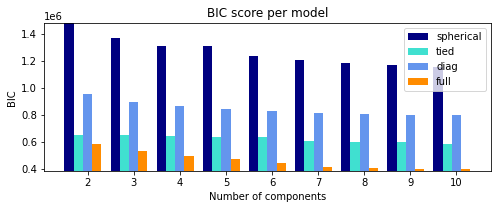

In [5]:
import itertools

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(cluster_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(cluster_range):
                                  (i + 1) * len(cluster_range)],
                        width=.2, color=color))
plt.xticks(cluster_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(cluster_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(cluster_range))
spl.set_xlabel('Number of components')
spl.set_ylabel('BIC')
spl.legend([b[0] for b in bars], cv_types)

Again the BIC keeps decreasing as more components are added, no optimum

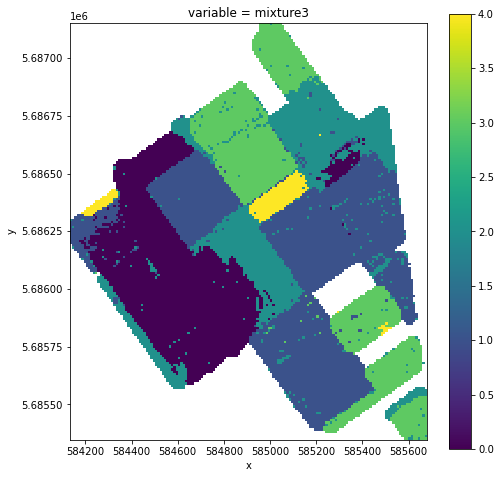

In [6]:
model = GaussianMixture(n_components = 5, covariance_type='full').fit(df_nona)
clusters = model.predict(df_nona) # each pixel assigned to cluster that has largest probability

cl = np.empty((28055))
cl[:] = np.nan

cl[~rows_with_nan] = clusters

df_raster['mixture3'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='mixture3').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

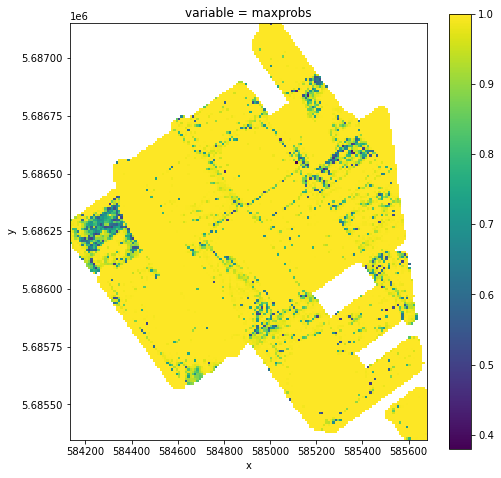

In [19]:
probs = model.predict_proba(df_nona)
maxprobs = probs.max(axis=1)

cl = np.empty((28055))
cl[:] = np.nan
cl[~rows_with_nan] = maxprobs
df_raster['maxprobs'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')
cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='maxprobs').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')